<a href="https://colab.research.google.com/github/Youssef-91/WelcomeMe/blob/New_Branche/Surface_Price_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Affichage avec la bibliothèque graphique intégrée à Notebook
%matplotlib inline

#_______________________________________________________
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from google.colab import files
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import io

**Première phase: exploration/nettoyage des donnée**

In [6]:
# Chargement des données
uploaded = files.upload()

Saving house_data.csv to house_data.csv


In [7]:
import io
raw_data = pd.read_csv(io.BytesIO(uploaded['house_data.csv']))

In [8]:
# Résumé des données brutes
raw_data.describe()

,price,surface,arrondissement
count,827.000000,822.000000,822.000000
mean,2007.342201,58.045925,4.142336
std,1890.894229,44.827522,3.202151
min,390.000000,10.000000,1.000000
25%,1050.000000,28.655000,2.000000
50%,1567.000000,46.100000,3.000000
75%,2346.000000,73.000000,4.000000
max,25000.000000,415.000000,10.000000


In [9]:
# Il y a quelques valeurs manquantes, on supprime ces lignes
data_na = raw_data.dropna()

# Comme vu dans le TP, on a des outliers sur les grands propriétés
data = data_na[data_na["price"] < 8000]

# On reindexe
data = data.reset_index(drop = True)

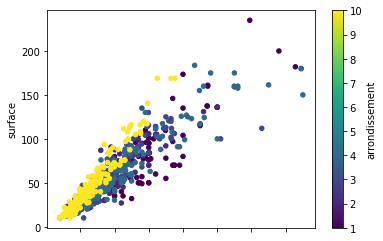

In [10]:
# On affiche les données nettoyées
data.plot.scatter("price", "surface", c="arrondissement", colormap='viridis')

**Il y a clairement un problème d'hétéroscédasticité, mais ce n'est pas le sujet de l'activité. On affiche maintenant la variable prédite (loyer) en fonction de l'arrondissement**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


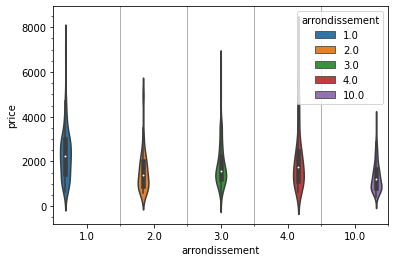

In [13]:
ax1 = sns.violinplot("arrondissement", "price", data=data, hue='arrondissement')
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which='minor', axis='x', linewidth=1)

**La répartition des prix semble a peu près la même, avec moins de loyers élévés (+volatiles) dans le 10ème. Si on considère qu'on a des échantillons représentatifs. Il faut de toute manière croiser avec la surface pour avoir une vision plus claire**

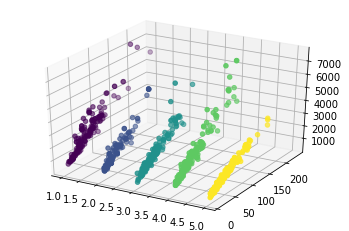

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure().gca(projection='3d')

# Pour faciliter la visualisation, on va changer la valeur de l'arrondissement (10)
tmp_arr = data['arrondissement'][:]
tmp_arr[tmp_arr == 10] = 5

fig.scatter(tmp_arr, data['surface'], data['price'], c=tmp_arr, cmap="viridis")
plt.show()

**On va effectuer une régression specifique sur chaque arrondissement, pour avoir plus de précision. D'abord, séparation jeu de données d'entraînement / jeu de données test**

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(data[["surface", "arrondissement"]], data[["price"]], test_size=0.3)

**Créons ensuite la baseline, et calculons le R2 (la somme quadratique des résidus), comme valeur d'évaluation de notre regression.**

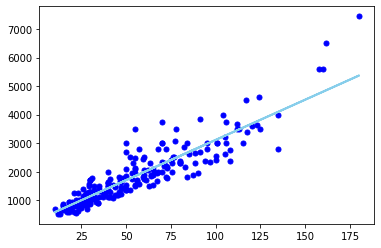

In [17]:
lr = LinearRegression()
lr_baseline = lr.fit(xtrain[["surface"]], ytrain)
baseline_pred = lr_baseline.predict(xtest[["surface"]])

plt.plot(xtest[["surface"]], ytest, 'bo', markersize = 5)
plt.plot(xtest[["surface"]], baseline_pred, color="skyblue", linewidth = 2)

**On réécrit rapidement le calcul du R2 score**

In [20]:
def sumsq(x,y):
    return sum((x - y)**2)

def r2score(pred, target):
    return 1 - sumsq(pred, target) / sumsq(target, np.mean(target))

score_bl = r2score(baseline_pred[:,0], ytest['price'])

print (score_bl)

0.8370802523765124


In [21]:
lrs = []
for i in np.unique(xtrain["arrondissement"]):
    
    # On génère un jeu de données par arrondissement
    tr_arr = xtrain['arrondissement']==i
    te_arr = xtest['arrondissement']==i
    
    xtrain_arr = xtrain[tr_arr]
    ytrain_arr = ytrain[tr_arr]

    xtest_arr = xtest[te_arr]
    ytest_arr = ytest[te_arr]

    lr = LinearRegression()
    lr.fit(xtrain_arr[["surface"]], ytrain_arr)
    lrs.append(lr)

**On effectue la prédiction finale sur le jeu de donnée test avec notre nouveau modèle, qui combine les différents modèles par arrondissement**

In [22]:
final_pred = []

for idx,val in xtest.iterrows():
    final_pred.append(lrs[int(val["arrondissement"]-1)].predict([[val["surface"]]])[0][0])
    
r2score(final_pred, ytest["price"])

0.879517836413444

**On peut afficher cette prédiction finale**

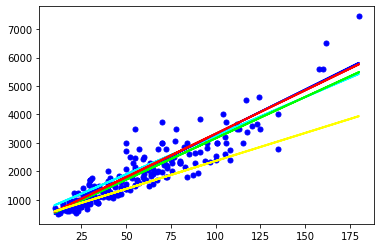

In [23]:
plt.plot(xtest[["surface"]], ytest, 'bo', markersize = 5)
plt.plot(xtest[["surface"]], lrs[0].predict(xtest[["surface"]]), color="#00FFFF", linewidth = 2)
plt.plot(xtest[["surface"]], lrs[1].predict(xtest[["surface"]]), color="#0000FF", linewidth = 2)
plt.plot(xtest[["surface"]], lrs[2].predict(xtest[["surface"]]), color="#00FF00", linewidth = 2)
plt.plot(xtest[["surface"]], lrs[3].predict(xtest[["surface"]]), color="#FF0000", linewidth = 2)
plt.plot(xtest[["surface"]], lrs[4].predict(xtest[["surface"]]), color="#FFFF00", linewidth = 2)

**Quelques features supplémentaires que l'on pourrait ajouter pour améliorer ce modèle :**

*   la distance aux écoles ou bouche de métro;
*   la localisation (Lat/long) ce qui permettrait d'explorer une approche avec un modèle Knn;
*   l'étage;
*   avec ou sans ascenseur;
*   neuf/ancien;
...